## From mord
These first few cells are taken directly from the ordinal regression package, with some modifications for the logistic regression with weights for quantile elicitation

In [1]:
import numpy as np
from scipy import optimize
import scipy
from sklearn import base, metrics
from sklearn.utils.validation import check_X_y
from classifiers import *
from data_generation import *

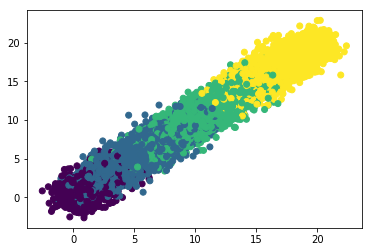

In [32]:
d = 2
w = np.array([1]*d) 
portions = np.array([2, 6, 8, 10]) * 2
k = 4
n = 10000
X, y = generate_quantile_data(d,k,n, portions)
# Visualize Data
from matplotlib import pyplot as plt
plt.scatter([X[:, 0]], [X[:, 1]], c=[y])

## Tests

## Quantile Elicitation

In [54]:
def compute_quantile(X_test, alpha):
    ## Known from data generation
    d = 2
    w = np.array([1]*d)
    portions = np.array([2, 6, 8, 10]) * 2
    k = 4
    
    projection_points = np.array(X_test.dot(w)) / np.dot(w,w)
    return get_class_quantiles(projection_points[0], portions, k, alpha)
    
def get_class_quantiles(projection_points, portions, k, alpha):
    y = np.matrix(np.ones(projection_points.size)).T
    for i in range(0, projection_points.size):
        curr_point = projection_points[i]
        likely_class = np.argmax((curr_point - portions) < 0)
        if(likely_class == k - 1 or curr_point > portions[-1]):
            y[i] = k-1
        else:
            if(likely_class > 0):
                prob_up = 1 - (portions[likely_class] - curr_point) / (portions[likely_class] - portions[likely_class - 1])
            else:
                prob_up = 1 - (portions[likely_class] - curr_point) / (portions[likely_class] - 0)
            y[i] = likely_class + 1 * (prob_up > 1 - alpha)
    return y

def weighted_absolute_loss(u, y, alpha):
    return np.mean((1 - alpha) * np.maximum((u - y), 0) + alpha * np.maximum((y - u), 0))

In [40]:
## Known from data generation
d = 2
portions = np.array([2, 6, 8, 10]) * 2
k = 4
n = 10000
X_train,y_train = generate_quantile_data(d, k, n, portions)
X_test,y_test = generate_quantile_data(d, k, n, portions)
y_train = y_train.astype(int)

In [45]:
def train_linear_classifiers(X_train, y_train, X_test, y_test, a):
    results = {}
    y_quantiles = compute_quantile(X_test, a).astype(int)
    clf5 = LogisticQuantileIT(gamma=a, alpha=1.)
    clf5.fit(X_train, y_train)
    abs_loss = weighted_absolute_loss(clf5.predict(X_test), y_test, a)
    zo_loss = metrics.zero_one_loss(clf5.predict(X_test), y_quantiles)
    print('Weighted Absolute Loss of LogisticQuantileIT, gamma=' + str(a) + ' %s' %
          abs_loss)
    print('0-1 Loss of LogisticQuantileIT, gamma=' + str(a) + ' %s' %
          zo_loss)
    results[clf5] = {'AbsLoss': abs_loss, 'ZoLoss': zo_loss}

    clf6 = LogisticQuantileAT(gamma=a, alpha=1.)
    clf6.fit(X_train, y_train)
    zo_loss = metrics.zero_one_loss(clf6.predict(X_test), y_quantiles)
    abs_loss = weighted_absolute_loss(clf6.predict(X_test), y_test, a)
    print('Weighted Absolute Loss of LogisticQuantileAT, gamma=' + str(a) + ' %s' %
          abs_loss)
    print('0-1 Loss of LogisticQuantileAT, gamma=' + str(a) + ' %s' %
          zo_loss)
    results[clf6] = {'AbsLoss': abs_loss, 'ZoLoss': zo_loss}
    
    clf7 = DirectQuantile(gamma=a, alpha=1.)
    clf7.fit(X_train, y_train)
    abs_loss = weighted_absolute_loss(clf7.predict(X_test), y_test, a)
    zo_loss = metrics.zero_one_loss(clf7.predict(X_test), y_quantiles)
    print('Weighted Absolute Loss of DirectQuantile, gamma=' + str(a) + ' %s' %
          abs_loss)
    print('0-1 Loss of DirectQuantile, gamma=' + str(a) + ' %s' %
          zo_loss)
    results[clf7] = {'AbsLoss': abs_loss, 'ZoLoss': zo_loss}
    return results

In [46]:
a1, a2, a3 = 0.3, 0.5, 0.75
results_linear_a1 = train_linear_classifiers(X_train, y_train, X_test, y_test, a1)

results_linear_a2 = train_linear_classifiers(X_train, y_train, X_test, y_test, a2)

results_linear_a3 = train_linear_classifiers(X_train, y_train, X_test, y_test, a3)

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Weighted Absolute Loss of LogisticQuantileIT, gamma=0.3 0.5244436000000039
0-1 Loss of LogisticQuantileIT, gamma=0.3 0.032299999999999995
Weighted Absolute Loss of LogisticQuantileAT, gamma=0.3 0.5241759500000023
0-1 Loss of LogisticQuantileAT, gamma=0.3 0.03520000000000001
Weighted Absolute Loss of DirectQuantile, gamma=0.3 0.6810839199999975
0-1 Loss of DirectQuantile, gamma=0.3 0.7223999999999999
Weighted Absolute Loss of LogisticQuantileIT, gamma=0.5 0.53379495
0-1 Loss of LogisticQuantileIT, gamma=0.5 0.012900000000000023
Weighted Absolute Loss of LogisticQuantileAT, gamma=0.5 0.53317727
0-1 Loss of LogisticQuantileAT, gamma=0.5 0.012499999999999956
Weighted Absolute Loss of DirectQuantile, gamma=0.5 0.58108151
0-1 Loss of DirectQuantile, gamma=0.5 0.6800999999999999
Weighted Absolute Loss of LogisticQuantileIT, gamma=0.75 0.46848282
0-1 Loss of LogisticQuantileIT, gamma=0.75 0.044300000000000006
Weighted Absolute Loss of LogisticQuantileAT, gamma=0.75 0.46993172
0-1 Loss of Logis

## Plot Threshold Boundaries

LogisticQuantileIT(alpha=1.0, gamma=0.75, max_iter=1000, verbose=0)


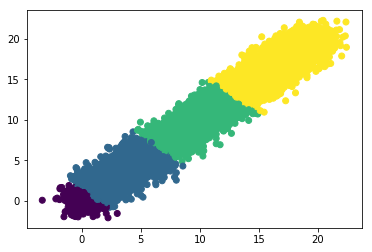

LogisticQuantileAT(alpha=1.0, gamma=0.75, max_iter=1000, verbose=0)


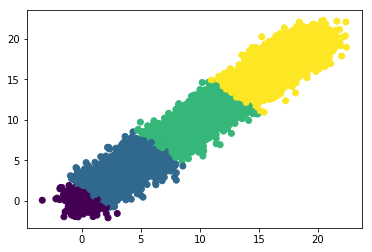

DirectQuantile(alpha=1.0, gamma=0.75, max_iter=1000, verbose=0)


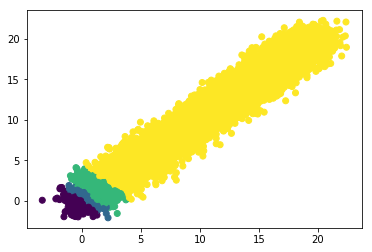

In [53]:
curr = results_linear_a3
for clf in curr.keys():
    print(clf)
    plt.scatter([X_test[:, 0]], [X_test[:, 1]], c=[np.matrix(clf.predict(X_test)).T])
    plt.show()

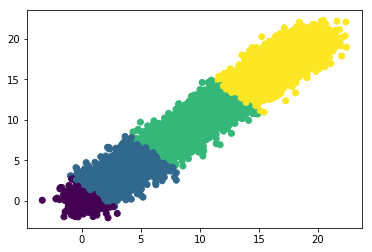

In [52]:
y_quantiles = compute_quantile(X_test, a3).astype(int)
plt.scatter([X_test[:, 0]], [X_test[:, 1]], c=[y_quantiles])

In [ ]:
np.max(y_quantiles)